# KTH Actions Data Set - Loading and Classification in  Python
**Author:** Christian Byron  **Date:** 15-Jun-21

This notebook provides an example of loading and classifying the KTH Action dataset. The KTH dataset is one of the most standard datasets, which contains six actions: walk, jog, run, box, hand-wave, and hand clap. To account for performance nuance, each action is performed by 25 different individuals, and the setting is systematically altered for each action per actor. Setting variations include: outdoor (s1), outdoor with scale variation (s2), outdoor with different clothes (s3), and indoor (s4). These variations test the ability of each algorithm to identify actions independent of the background, appearance of the actors, and the scale of the actors.

- [ ] 

### Step 1 - Load the KTH data from the saved location

In [1]:
import torch
from torchvision import datasets, transforms

classes = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]

base_image_collection_path = "C:\\Users\\s441606\\Documents\\Images\\KTH_Actions"

transform = transforms.ToTensor()
dataset = datasets.ImageFolder(base_image_collection_path, transform=transform)
#print(dataset)

trainset, validset, testset, disposeset = torch.utils.data.random_split(dataset, [1024, 1024, 1024, 286536])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

validloader  = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)

valloader  = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [2]:
import matplotlib.pyplot as plt
import random

# Run this to test your data loader
images, labels = next(iter(trainloader))
# helper.imshow(images[0], normalize=False)

random_num = random.randint(0, len(images))
#imshow(images[random_num ], normalize=False)
plt.imshow(images[random_num].numpy().transpose((1, 2, 0)))
print(classes[labels[random_num]])


walking


### Step 2 - Create the neural network

In [3]:
import torch 
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, \
                     MaxPool2d, Module, LogSoftmax, BatchNorm2d, Dropout

from torch.optim import Adam, SGD


class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(                          # input image size (3,160,120)
            # Defining a 2D convolution layer
            Conv2d(3, 64, kernel_size=5, stride=1, padding=2),  # outputize (64,160,120)
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                # outputize (64,80,60)
            
            # Defining another 2D convolution layer
            Conv2d(64, 32, kernel_size=5, stride=1, padding=2),# outputize (32,80,60)
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                # outputize (32,40,30)
            
            # Defining final 2D convolution layer
            Conv2d(32, 16, kernel_size=5, stride=1, padding=2), # outputize (16,40,30)
            BatchNorm2d(16),
            ReLU(inplace=True)

        )

        self.linear_layers = Sequential(
            Linear(16 * 40 * 30, 6),
            LogSoftmax(dim=1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    

# defining the model
model = Net()

if torch.cuda.is_available():
    model = model.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=19200, out_features=6, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


### Step3 - Initialize the network and the optimizer.

In [4]:
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = CrossEntropyLoss()


### Step 4 - The core training process

In [5]:
from time import time
import numpy as np

epochs = 15
time0 = time()

min_valid_loss = np.inf
eval_losses=[]
eval_accu=[]
train_losses=[]
train_accu=[]

for e in range(epochs):
    
    model.train()
    running_train_loss=0
    correct=0
    total=0
    
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        
        loss.backward()
        optimizer.step()
        
        #evaulate and record the training progress  - first loss, then accuracy
        running_train_loss += loss.item() 
        train_losses.append(running_train_loss / (len(train_losses) % len(trainloader) + 1))
        
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item() 
        train_accu.append(100.*correct/total)
    

    model.eval()     
    running_valid_loss=0
    correct=0
    total=0
    
    for images, labels in validloader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        
        output = model(images)
        loss = criterion(output,labels)
        
        running_valid_loss += loss.item() 
        eval_losses.append(running_valid_loss / (len(eval_losses) % len(validloader) + 1 ))
        
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item() 
        eval_accu.append(100.*correct/total)
        
    print(f'Epoch {e+1} - Training Loss: {running_train_loss / len(trainloader):.3f} \
          \t Validation Loss: {running_valid_loss / len(validloader):.3f}')
    if min_valid_loss > running_valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.3f} -> {running_valid_loss:.3f}) \t Saving The Model')
        min_valid_loss = running_valid_loss
        torch.save(model.state_dict(), 'saved_model.pth')
        
print(f'\nTraining Time (in minutes) = {(time()-time0)/60:.3f}')

Epoch 1 - Training Loss: 23.922           	 Validation Loss: 14.390
Validation Loss Decreased(inf -> 460.477) 	 Saving The Model
Epoch 2 - Training Loss: 5.495           	 Validation Loss: 4.896
Validation Loss Decreased(460.477 -> 156.674) 	 Saving The Model
Epoch 3 - Training Loss: 2.545           	 Validation Loss: 1.855
Validation Loss Decreased(156.674 -> 59.349) 	 Saving The Model
Epoch 4 - Training Loss: 1.514           	 Validation Loss: 1.569
Validation Loss Decreased(59.349 -> 50.207) 	 Saving The Model
Epoch 5 - Training Loss: 1.139           	 Validation Loss: 1.373
Validation Loss Decreased(50.207 -> 43.951) 	 Saving The Model
Epoch 6 - Training Loss: 1.048           	 Validation Loss: 1.393
Epoch 7 - Training Loss: 0.958           	 Validation Loss: 1.321
Validation Loss Decreased(43.951 -> 42.266) 	 Saving The Model
Epoch 8 - Training Loss: 0.889           	 Validation Loss: 1.367
Epoch 9 - Training Loss: 0.815           	 Validation Loss: 1.373
Epoch 10 - Training Loss:

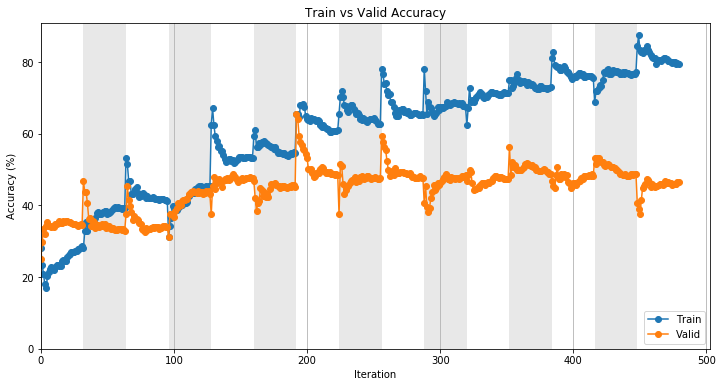

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')

for i in range(32,480, 64): 
    plt.axvspan(i, i+32, facecolor='lightgrey', alpha=0.5)
    
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.grid(axis='x')
plt.show()

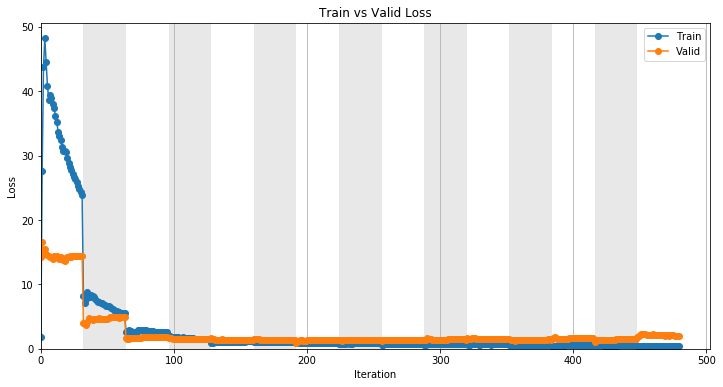

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('Iteration')
plt.ylabel('Loss')

for i in range(32,480, 64): 
    plt.axvspan(i, i+32, facecolor='lightgrey', alpha=0.5)

plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid(axis='x')

plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

### Step 5 - Testing & Evaluation

In [8]:
import numpy as np

pred_label = []
true_label = []

for images,labels in valloader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    for i in range(len(labels)):
        img = images[i].view(1, 3, 120, 160)
        with torch.no_grad():
            logps = model(img)


        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label.append(  probab.index(max(probab)))
        true_label.append(labels.numpy()[i])

print(len(pred_label))

1024


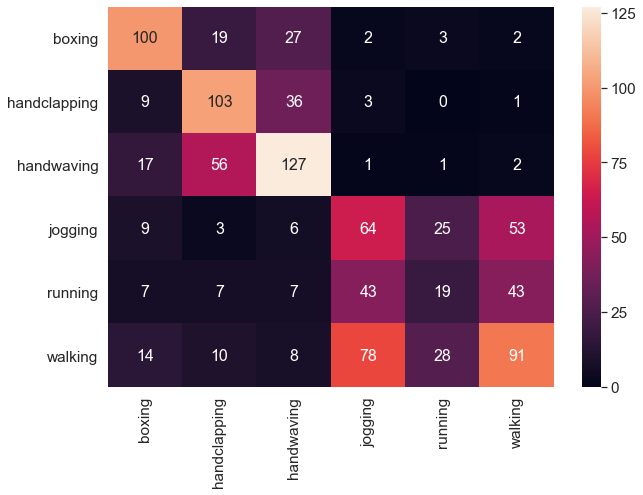

49.22%


In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(true_label, pred_label)

df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.show()

print(f"{accuracy_score(true_label, pred_label):.2%}")

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score

model = Net()
model.load_state_dict(torch.load('saved_model.pth'))

if torch.cuda.is_available():
    model = model.cuda()
    
pred_label = []
true_label = []

model.eval()
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 3, 120, 160)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label.append(  probab.index(max(probab)))
    true_label.append(labels.numpy()[i])
    
print(f"{accuracy_score(true_label, pred_label):.2%}")

50.29%


### Step 6 - Visualise the CNN Filters

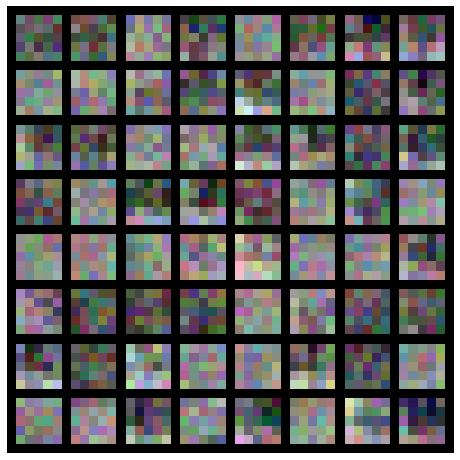

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))



filter = model.cnn_layers[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

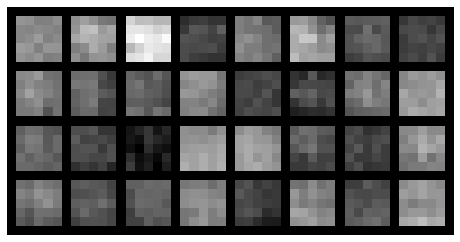

In [12]:
filter = model.cnn_layers[4].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

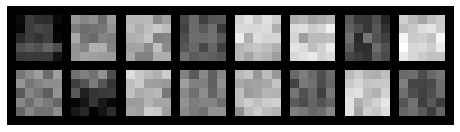

In [13]:
filter = model.cnn_layers[8].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

### Step 7 - Visualise the Activation heatmap

In [17]:
from random import randint

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.eval
model.cnn_layers[8].register_forward_hook(get_activation('conv1'))
data, _ = disposeset[randint(1,100)]
data.unsqueeze_(0)
output = model(data)
_, (pred,) = torch.max(output, 1)

act = activation['conv1'].squeeze()


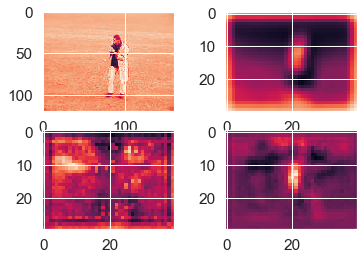

In [18]:
weights = model.linear_layers[0]._parameters['weight'][pred].view(16,30,40)
cam = (act * weights).sum(0)

fig, axarr = plt.subplots(2,2)
axarr[0,0].imshow(data[0,0])
axarr[0,1].imshow(act[0])
axarr[1,0].imshow(weights[0].detach().numpy())
axarr[1,1].imshow(cam.detach().numpy())

#### Lessons Learnt

- The proper installation sequence to get GPU (CUDA) support for pytorch - reduced the runtime from 15 mins (on laptop) to 4 mins (on HCC workstation using CPU) to 45 secs (on HCC workstation using GPU).. Last issue was around compatibility of the graphics card ( ie https://github.com/pytorch/pytorch/issues/45028)
